Task:

create classificators and compare

classical features + knn/svm/linear classificator\
CNN+MLP with your own architecture\
Finetuned CNN

## Load Data

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import zipfile
from warnings import filterwarnings
from IPython.display import clear_output
filterwarnings("ignore")

In [2]:
# donwload from gdrive
gdd.download_file_from_google_drive(file_id='1hENdCn752nO9BbQda7BRR0-miOtActjb',
                                    dest_path='./data/hw2.zip')

In [3]:
# unzip
with zipfile.ZipFile("./data/hw2.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

## classical features + knn/svm/linear classificator

I decided do not to concentrate a lot on classical features, in my opinion it's very specific task (however in my current project we are using random forest for image classification). I used LogisticRegression and KNN (SVM learn too much) and selected by hyperparameter optimization one best classifier. For features I used HOGs for 128x128 images and Flatten features for 32x32 images. 

In [4]:
from skimage.feature import hog
from pathlib import Path
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import optuna

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (10,8)

In [5]:
# load data
x_train, y_train = [], []
x_test, y_test = [], []

# load train data
for path in tqdm(Path('data/Classification_data/train/').rglob('*.jpg')):
    # load image
    im = cv2.imread(str(path))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # save image
    x_train.append(im)
    y_train.append(path.parent.name)
    
# load test data
for path in tqdm(Path('data/Classification_data/test/').rglob('*.jpg')):
    # load image
    im = cv2.imread(str(path))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # save image
    x_test.append(im)
    y_test.append(path.parent.name)
    
print(f"TrainSize: {len(x_train)}, TestSize: {len(x_test)}")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

TrainSize: 14034, TestSize: 3000


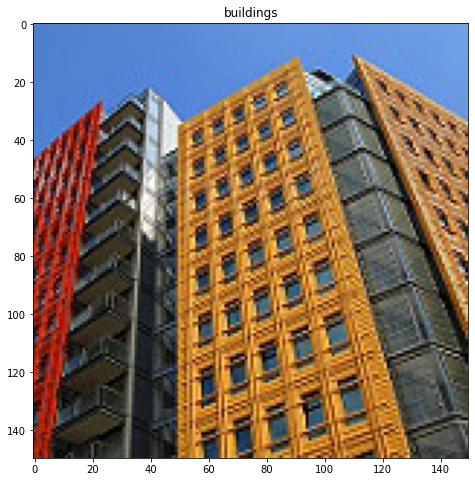

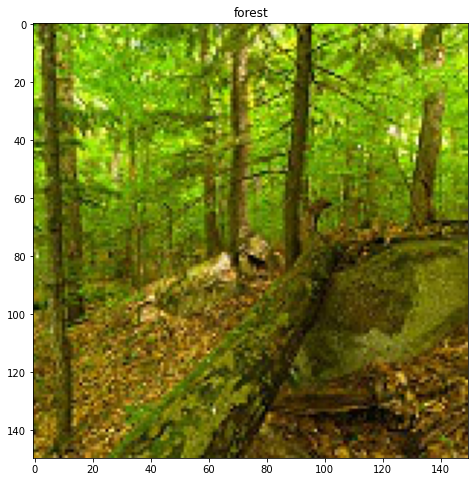

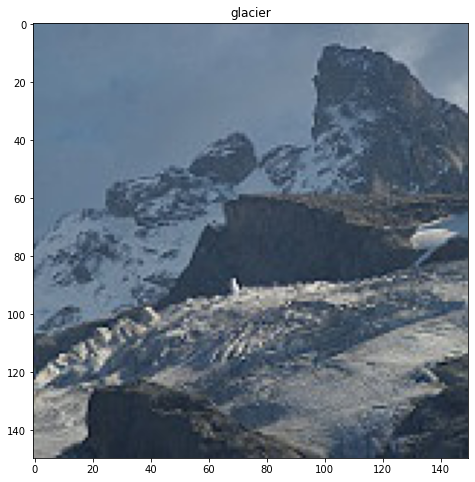

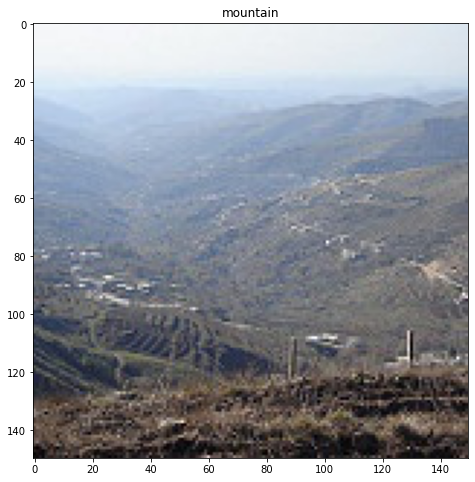

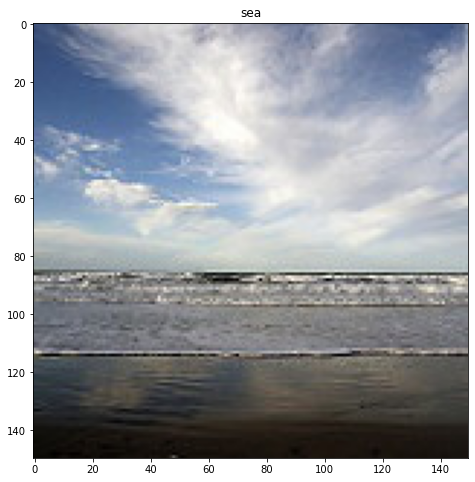

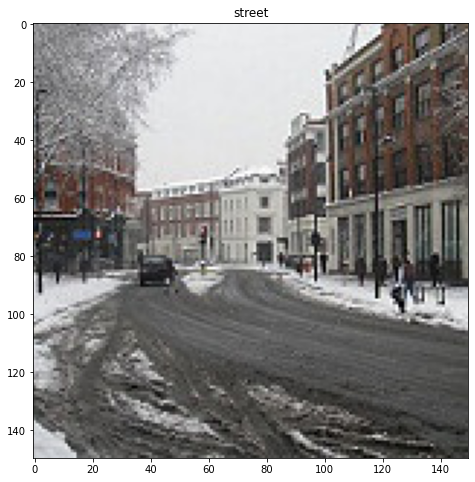

In [6]:
# vis
unique_classes = np.unique(y_train)
for ex_ind in range(len(unique_classes)):
    class_ = unique_classes[ex_ind]
    class_ind = np.where(np.array(y_train) == class_)[0][42]
    plt.imshow(x_train[class_ind])
    plt.title(class_)
    plt.show()

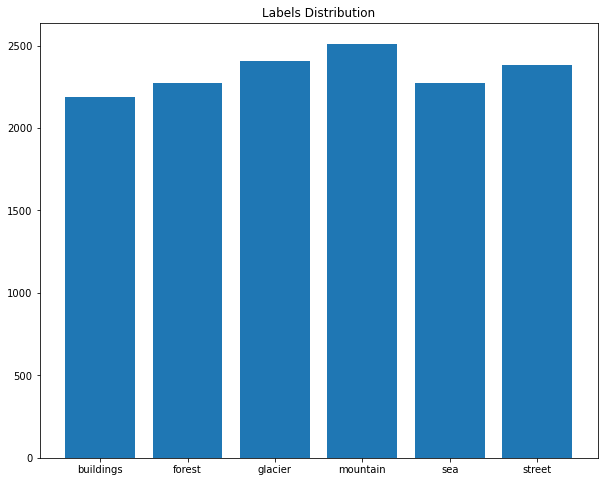

In [7]:
# labels are normally distributed -> we can use accuracy
plt.bar(x=np.unique(y_train, return_counts=True)[0], height= np.unique(y_train, return_counts=True)[1])
plt.title("Labels Distribution");

In [8]:
%%time
def get_features(im):
    # normalize
    im = im / 255
    # get hog (980 features)
    fd = hog(im, orientations=5, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False, multichannel=True)
    # get flatten(1024 features)
    im = cv2.resize(im, (32, 32))
    im = im.flatten()
    return im, fd
    
    
# resize
x_train_resize = [cv2.resize(im, (128, 128)) for im in x_train]
x_test_resize = [cv2.resize(im, (128, 128)) for im in x_test]
# get features
x_train_features = [get_features(im) for im in x_train_resize]
x_test_features = [get_features(im) for im in x_test_resize]
# flatten features
x_train_flatten = np.array([features[0] for features in x_train_features])
x_test_flatten = np.array([features[0] for features in x_test_features])
# hog features
x_train_hog = np.array([features[1] for features in x_train_features])
x_test_hog = np.array([features[1] for features in x_test_features])
# y
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Wall time: 59.5 s


In [9]:
# optimize
def objective(trial):
    # select model
    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "KNN"])
    # select hyperparameters
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(C=logreg_c)
    elif classifier_name == "KNN":
        n_neighbors = trial.suggest_int("n_neighbors", 3, 25)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)

    score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [10]:
# Flatten Features
X, y = x_train_flatten, y_train
study_flatten = optuna.create_study(direction="maximize")
study_flatten.optimize(objective, n_trials=30)
clear_output()

In [11]:
# Hog Features
X, y = x_train_hog, y_train
study_hog = optuna.create_study(direction="maximize")
study_hog.optimize(objective, n_trials=30)
clear_output()

In [12]:
print(f"Flatten: {study_flatten.best_params}")
print(f"HOG: {study_hog.best_params}")

Flatten: {'classifier': 'LogReg', 'C': 0.006476260187612742}
HOG: {'classifier': 'LogReg', 'C': 0.04910857557363257}


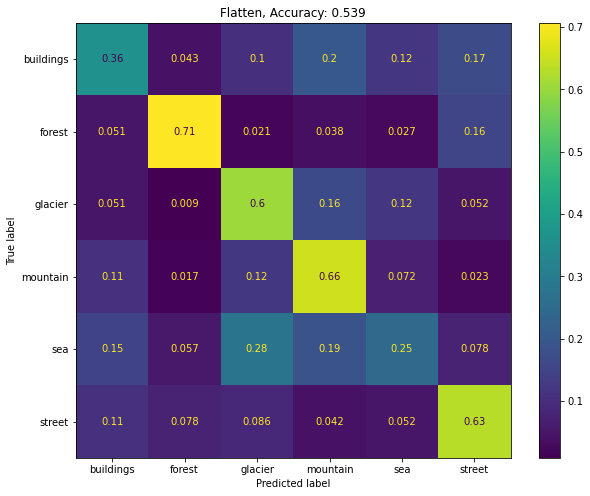

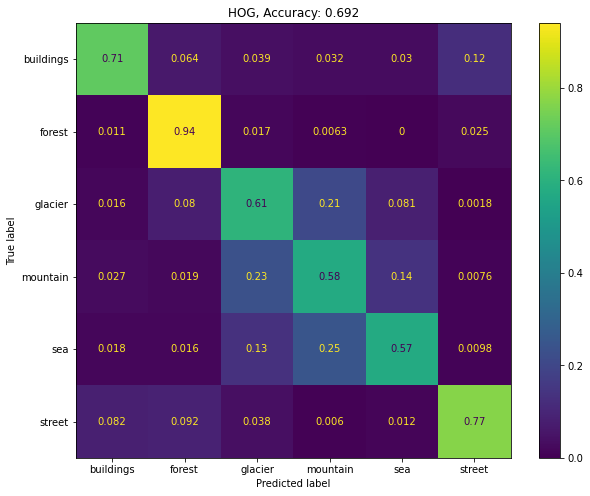

In [13]:
# vis results
# for flatten
if study_flatten.best_params["classifier"] == "LogReg":
    est = LogisticRegression(C=study_flatten.best_params["C"])
elif study_flatten.best_params["classifier"] == "KNN":
    est = LogisticRegression(n_neighbors=study_flatten.best_params["n_neighbors"])

est.fit(x_train_flatten, y_train)
preds = est.predict(x_test_flatten)
cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot()
plt.title(f"Flatten, Accuracy: {round((preds == y_test).mean(), 3)}")
plt.show()

# for HOG
if study_hog.best_params["classifier"] == "LogReg":
    est = LogisticRegression(C=study_hog.best_params["C"])
elif study_hog.best_params["classifier"] == "KNN":
    est = LogisticRegression(n_neighbors=study_hog.best_params["n_neighbors"])
    
est.fit(x_train_hog, y_train)
preds = est.predict(x_test_hog)
cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot()
plt.title(f"HOG, Accuracy: {round((preds == y_test).mean(), 3)}")
plt.show()

<b> Conclusion: </b> HOG features works better then flatten with accuracy about 0.69, but I think simple neural network will beat this baseline easily

## Neural Networks

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Simple CNN

Simple Convolutional networks with 3 ConvLayers and Maxpooling and 2 linear layers

In [15]:
batch_size = 32
img_height = 128
img_width = 128

full_train = keras.utils.image_dataset_from_directory("data/Classification_data/train", image_size=(img_height, img_width),
                                                      batch_size=batch_size)
train_ds = keras.utils.image_dataset_from_directory("data/Classification_data/train", validation_split=0.2,
                                                       subset="training", seed=42, image_size=(img_height, img_width),
                                                       batch_size=batch_size)
val_ds = keras.utils.image_dataset_from_directory("data/Classification_data/train", validation_split=0.2,
                                                     subset="validation", seed=42, image_size=(img_height, img_width),
                                                     batch_size=batch_size)
test_ds = keras.utils.image_dataset_from_directory("data/Classification_data/test", image_size=(img_height, img_width),
                                                        batch_size=batch_size, shuffle=False)

Found 14034 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [16]:
# model
num_classes = 6

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
# compile
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
351/351 [==============================] - 13s 30ms/step - loss: 2.9471 - accuracy: 0.5028 - val_loss: 1.0568 - val_accuracy: 0.5820
Epoch 2/10
351/351 [==============================] - 10s 29ms/step - loss: 0.8718 - accuracy: 0.6714 - val_loss: 0.8985 - val_accuracy: 0.6671
Epoch 3/10
351/351 [==============================] - 10s 29ms/step - loss: 0.6777 - accuracy: 0.7444 - val_loss: 0.8417 - val_accuracy: 0.7024
Epoch 4/10
351/351 [==============================] - 12s 32ms/step - loss: 0.4976 - accuracy: 0.8136 - val_loss: 1.0064 - val_accuracy: 0.6842
Epoch 5/10
351/351 [==============================] - 11s 31ms/step - loss: 0.3983 - accuracy: 0.8546 - val_loss: 0.9768 - val_accuracy: 0.7092
Epoch 6/10
351/351 [==============================] - 11s 30ms/step - loss: 0.3147 - accuracy: 0.8868 - val_loss: 0.9861 - val_accuracy: 0.7227
Epoch 7/10
351/351 [==============================] - 11s 30ms/step - loss: 0.2801 - accuracy: 0.9011 - val_loss: 1.1792 - val_accuracy:

In [18]:
# evaluate
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
epochs=10
history = model.fit(full_train, epochs=epochs, verbose=0)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"TestAccuracy: {test_accuracy}")

94/94 [==============================] - 2s 17ms/step - loss: 1.4591 - accuracy: 0.7307
TestAccuracy: 0.7306666374206543


Not bad score, but the main problem is overfitting. Let's try to prevent overfitting by batchnorm, scheduler and skip connections (I want to check how can these techniques work without early stopping and checkpoints -> I want to use result model for evaluation)

## Deeper CNN

Three blocks with conv and skip connection + data augmentation + scheduler

In [19]:
# model
num_classes = 6

def castom_conv(channels, kernel):
    return Sequential([layers.Conv2D(channels, kernel, padding="same", use_bias=False),
                       layers.BatchNormalization(),
                       layers.ReLU()])

data_augmentation = Sequential([
    layers.Rescaling(1./255),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
])

def get_model(config):
    '''
    Model Architecture
    '''
    # inputs and augmentation
    inputs = layers.Input(shape=(img_width, img_height, 3))
    x = data_augmentation(inputs)
    
    # block1
    x_connect = castom_conv(config["channels1"], config["kernel1"])(x)
    x = castom_conv(config["channels1"], config["kernel1"])(x_connect)
    x = castom_conv(config["channels1"], config["kernel1"])(x)
    x = layers.add([x_connect, x])
    x = layers.MaxPooling2D()(x)
    
    # block2
    x_connect = castom_conv(config["channels2"], config["kernel2"])(x)
    x = castom_conv(config["channels2"], config["kernel2"])(x_connect)
    x = castom_conv(config["channels2"], config["kernel2"])(x)
    x = layers.add([x_connect, x])
    x = layers.MaxPooling2D()(x)
    
    # block3
    x_connect = castom_conv(config["channels3"],  config["kernel3"])(x)
    x = castom_conv(config["channels3"], config["kernel3"])(x_connect)
    x = castom_conv(config["channels3"], config["kernel3"])(x)
    x = layers.add([x_connect, x])
    x = layers.MaxPooling2D()(x)
    
    # block4
    x_connect = castom_conv(config["channels4"], config["kernel4"])(x)
    x = castom_conv(config["channels4"], config["kernel4"])(x_connect)
    x = castom_conv(config["channels4"], config["kernel4"])(x)
    x = layers.add([x_connect, x])
    x = layers.MaxPooling2D()(x)
    
    # block5
    x_connect = castom_conv(config["channels5"], config["kernel5"])(x)
    x = castom_conv(config["channels5"], config["kernel5"])(x_connect)
    x = castom_conv(config["channels5"], config["kernel5"])(x)
    x = layers.add([x_connect, x])
    x = layers.MaxPooling2D()(x)
    
    # output
    x = layers.Dropout(config["dropout"])(x)
    x = layers.Flatten()(x)
    x = layers.Dense(config["linear"], activation='relu')(x)
    output = layers.Dense(num_classes)(x)
    
    return keras.Model(inputs, output)

In [20]:
# model
config = {"channels1":16, "channels2":32, "channels3":64, "channels4":128, "channels5":256, "channels6":512,
          "kernel1":7, "kernel2":3, "kernel3":3, "kernel4":3, "kernel5":3, "kernel6":3,
          "dropout":0.2, "linear":128}
model = get_model(config)

# compile
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=50, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# train
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs) 

Epoch 1/10
351/351 [==============================] - 61s 165ms/step - loss: 1.4568 - accuracy: 0.4589 - val_loss: 1.1968 - val_accuracy: 0.4818
Epoch 2/10
351/351 [==============================] - 57s 160ms/step - loss: 0.8793 - accuracy: 0.6592 - val_loss: 0.7908 - val_accuracy: 0.7103
Epoch 3/10
351/351 [==============================] - 57s 160ms/step - loss: 0.6890 - accuracy: 0.7412 - val_loss: 0.6420 - val_accuracy: 0.7666
Epoch 4/10
351/351 [==============================] - 57s 161ms/step - loss: 0.5863 - accuracy: 0.7826 - val_loss: 0.6069 - val_accuracy: 0.7787
Epoch 5/10
351/351 [==============================] - 57s 161ms/step - loss: 0.5236 - accuracy: 0.8111 - val_loss: 0.5010 - val_accuracy: 0.8254
Epoch 6/10
351/351 [==============================] - 57s 160ms/step - loss: 0.4932 - accuracy: 0.8248 - val_loss: 0.4870 - val_accuracy: 0.8254
Epoch 7/10
351/351 [==============================] - 57s 161ms/step - loss: 0.4721 - accuracy: 0.8332 - val_loss: 0.4644 - val_ac

In [21]:
# evaluate
# model
model = get_model(config)

# compile
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=50, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# train
epochs=10
history = model.fit(full_train, epochs=epochs, verbose=0) 

# test
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"TestAccuracy: {test_accuracy}")

94/94 [==============================] - 5s 43ms/step - loss: 0.3997 - accuracy: 0.8587
TestAccuracy: 0.8586666584014893


That architecture works better (not too much). Also I tested others different augmentations, made network deeper, added more layers, test-time augmentation and etc.

### ResNet50

Let's test pretrained network

In [22]:
def get_model():
    # load pretrained model
    pretrained = keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=None,
                                             input_shape=(img_width, img_height, 3))
    pretrained.trainable = False
    # add trainable heaad
    inputs = layers.Input(shape=(img_width, img_height, 3))
    x = pretrained(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes)(x)
    
    return keras.Model(inputs, output)

In [23]:
#model
model = get_model()

# compile
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# train
epochs=5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs) 

Epoch 1/5
351/351 [==============================] - 46s 123ms/step - loss: 0.6282 - accuracy: 0.8500 - val_loss: 0.3323 - val_accuracy: 0.8867A: 29s - loss: 1.9282 - - ETA: 27s - loss: 1.5697 - ac - ETA: 26s - loss: 1.4144 - accura - ETA: 25s - los - ETA: 22s - loss: 1.0900 - accuracy: 0.8 - ETA: 22s - loss: 1.07 - ETA: 20s - loss: 0.9888 - accura - ETA: 19s - loss: 0.9544 - accura - ETA: 18s - loss: 0.9245 -  - E - ETA: 1s - loss: 0
Epoch 2/5
351/351 [==============================] - 42s 120ms/step - loss: 0.2132 - accuracy: 0.9261 - val_loss: 0.3325 - val_accuracy: 0.8967: 0.2255 - accu - E - ETA: 13s -  - ETA: 10s  - ETA: 8s - loss: 0.2179 - accuracy -
Epoch 3/5
351/351 [==============================] - 42s 120ms/step - loss: 0.1237 - accuracy: 0.9553 - val_loss: 0.3591 - val_accuracy: 0.9006: 32s - loss: 0.1650 - accuracy - ETA: 31s - loss: 0.1440 - - - ETA: 5s - loss: 0.1256  - ETA: 2s - loss: 0.1262 - accu - ETA: 1s - loss: 0.1255 - accuracy - ETA: 1s - loss:
Epoch 4/5
351/351

In [24]:
#evaluate
model = get_model()

# compile
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# train
epochs=5
history = model.fit(full_train, epochs=epochs, verbose=0) 

# test
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"TestAccuracy: {test_accuracy}")

94/94 [==============================] - 10s 97ms/step - loss: 0.4303 - accuracy: 0.8920
TestAccuracy: 0.8920000195503235


Pretrained model works better then previous architectures, even without some finetuning

<b><h2> Results </b>

|Model|Accuracy|
|-----|--------|
|CLassical (Flatten)|0.539|
|Classical (HOG)|0.692|
|Simple CNN|0.73|
|Deeper CNN|0.858|
|Pretrained|0.89|